Data analysis and figure production for

# Predicting microbial relative growth in a mixed culture from growth curve data

by Yoav Ram, Eynat Deluss-Gur, Maayan Bibi, Kedar Karkare, Uri Obolski, Tim F. Cooper, Judith Berman, and Lilach Hadany.

*A manuscript in preparation.*

#### Notebook
This [Jupyter notebook](http://jupyter.org/) is an electronic supplementry material to the article.

The notebook **will be available** at <https://github.com/yoavram/curveball_ms/blob/master/supp.ipynb>.

The [Curveball](http://curveball.yoavram.com) package, used to analyze growth curves, predict growth in a mixed culture, and infer relative fitness, will be found at <http://curveball.yoavram.com> or on [Github](https://github.com/yoavram/curveball).

Data deposited on FigShare (doi:10.6084/m9.figshare.3485984) and will be available upon publication.

In [122]:
import pkg_resources
import os
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress, norm
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import seaborn as sns

%matplotlib inline
sns.set(style='white', context='paper', font_scale=2, palette='Set1')
red, blue, green = sns.color_palette('Set1', 3)
width, height = plt.rcParams['figure.figsize']
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['lines.markersize'] = 7.5
panel_label_size = plt.rcParams[ 'axes.titlesize']*1.3
fit_ls = '-' # model fit linestyle
pred_ls = '--' # model prediction linestyle
fixed_pred_ls = '-.' # prediction without competition coefficients linestyle

In [123]:
import curveball
import curveball.scripts.cli
print('Curveball, ', curveball.__version__)
folder = 'data' # change to match your data folder
folder = folder if folder.startswith('/') else os.path.join(os.getcwd(), folder)
print('Working folder:', folder)

Curveball,  0.2.11+3.g98fd6be.dirty
Working folder: /Users/yoavram/Work/Research/Lilach/curveball_project/ms/data


In [124]:
from rakott.mpl import fig_xlabel, fig_ylabel, savefig_bbox, fig_panel_labels

In [19]:
datasets = collections.OrderedDict()
datasets['2015-11-18'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_181115.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_181115.xlsx'),
    'max_time': 12,
    'bad_wells': ['B2','E1','C4','A2'] + # G outliers
                 ['H9','C11','A10','C12','A11','A9','C9','H11'] + # R outliers
                 ['E5','E8','H6','H8','H7','H5'], # RG outliers
    'flow_summary_file': os.path.join(folder, 'flow', 'flow_df_2015-11-18.csv'),
    'lag': True,
    'ylim': (0, 0.8)
}
datasets['2015-12-14'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_141215.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_141215.xlsx'),
    'max_time': 7,
    'bad_wells': ['{}{}'.format(c, i) for c in 'ABCDEFGH' for i in range(4, 8)] + # used for flow samples
                 ['B10','B11','C10','A11','E11','A12', 'H11', 'G11', 'F11'] + # red outliers
                 ['D8','H8'], # RG outliers
    'flow_summary_file': os.path.join(folder, 'flow', 'flow_df_2015-12-14.csv'),
    'lag': False,
    'ylim': (0, 0.8)
}
datasets['2016-01-06'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_060116.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_060116.xlsx'),
    'max_time': 10,
    'bad_wells': 
                 ['A4','F4','G3'] + # G outliers
                 ['E12','A10','D10'] + # R outliers
                 ['H5','H6','G8'] , # RG outliers
    'flow_summary_file': os.path.join(folder, 'flow', 'flow_df_2016-01-06.csv'),
    'lag': True,
    'ylim': (0, 0.8)
}

In [20]:
for ds in datasets.values():
    ds['plate'] = pd.read_csv(ds['plate_file'])
    ds['df'] = curveball.ioutils.read_tecan_xlsx(ds['OD_file'], plate=ds['plate'], max_time=ds['max_time'])
    ds['df'] = ds['df'][~ds['df'].Well.isin(ds['bad_wells'])]
    ds['dfG'] = ds['df'][ds['df'].Strain.str.contains('GFP')]
    ds['dfR'] = ds['df'][ds['df'].Strain.str.contains('RFP')]
    ds['dfRG'] = ds['df'][ds['df'].Strain=='mixed']
    ds['RG0_mean'] = ds['dfRG'][(ds['dfRG'].Time==ds['dfRG'].Time.min())].OD.mean()
    ds['RG_time'] = ds['dfRG'].Time.unique()
    ds['RG_mean'] = ds['dfRG'].groupby(by='Time').OD.mean()
    ds['RG_std'] = ds['dfRG'].groupby(by='Time').OD.std(ddof=1)

In [21]:
for ds in datasets.values():
    param_fix = {'y0', 'K'}
    param_guess = None
    if not ds['lag']:
        param_fix.add('q0')
        param_fix.add('v')
        param_guess = {'q0': np.inf, 'v': np.inf}
    models_G = curveball.models.fit_model(ds['dfG'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    models_R = curveball.models.fit_model(ds['dfR'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    models_RG = curveball.models.fit_model(ds['dfRG'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    ds['model_R'] = models_R[0]
    ds['model_G'] = models_G[0]
    ds['model_RG'] = models_RG[0]

In [22]:
for name, ds in datasets.items():
    print(name, 'G', ds['model_G'].model.name)
    print(name, 'R', ds['model_R'].model.name)
    print(name, 'RG', ds['model_RG'].model.name)

2015-11-18 G Model(BaranyiRoberts)
2015-11-18 R Model(LogisticLag2)
2015-11-18 RG Model(LogisticLag2)
2015-12-14 G Model(BaranyiRoberts)
2015-12-14 R Model(BaranyiRoberts)
2015-12-14 RG Model(Logistic)
2016-01-06 G Model(LogisticLag2)
2016-01-06 R Model(BaranyiRoberts)
2016-01-06 RG Model(BaranyiRoberts)


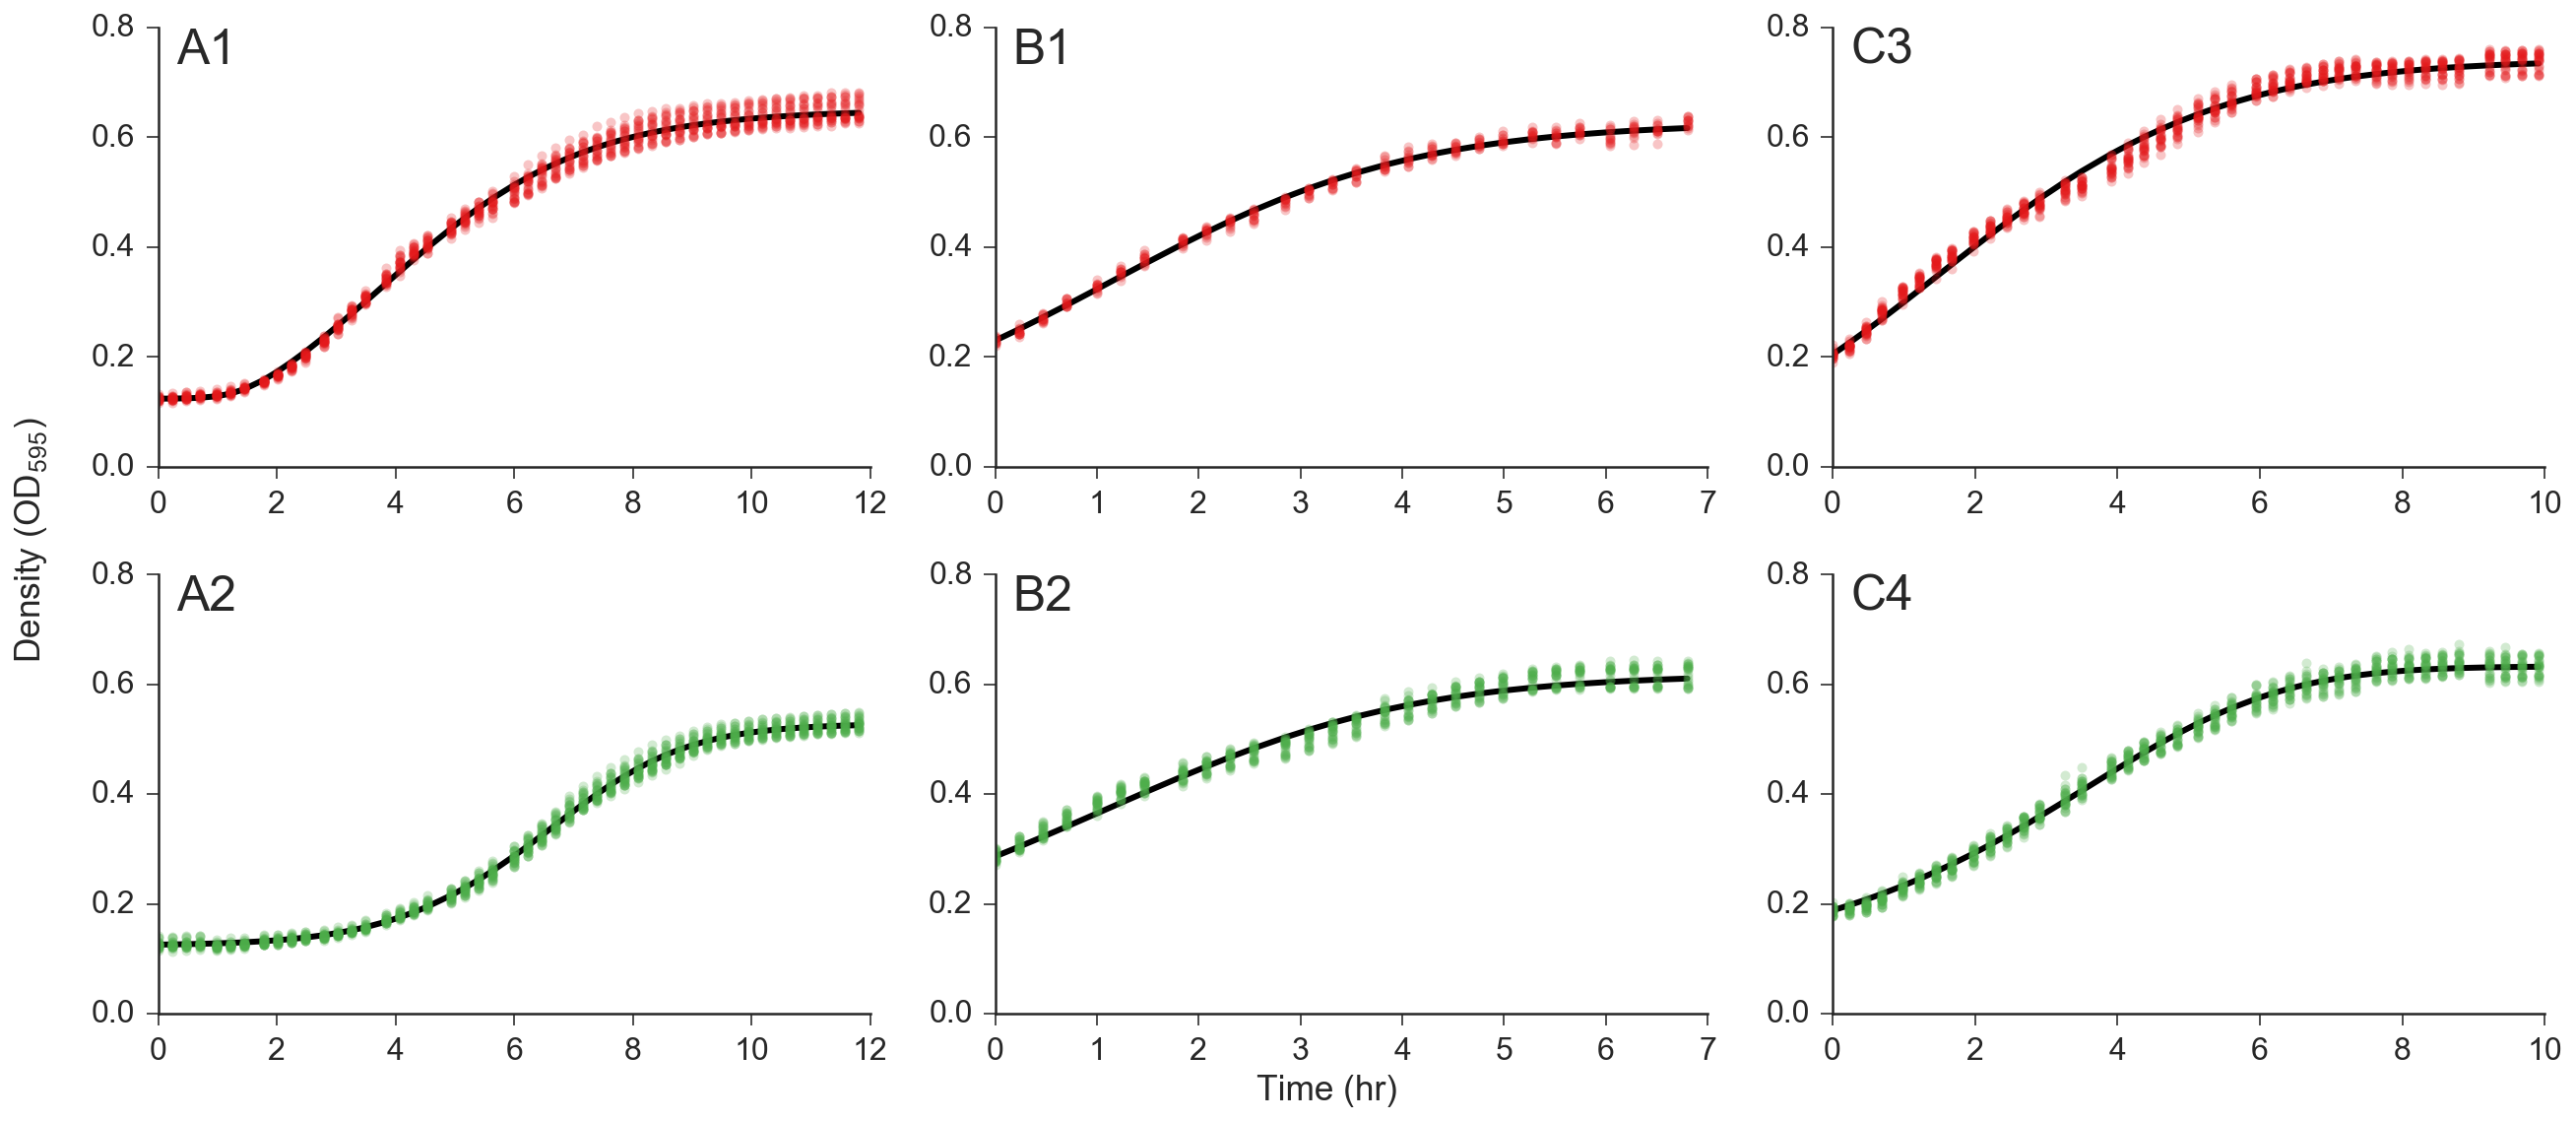

In [23]:
cols = len(datasets)
rows = 2
fig, ax = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=(width * cols, height * rows), squeeze=False)
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
for i, (name, ds) in enumerate(datasets.items()):
    # plot curves
#     grouped = ds['dfG'].groupby('Well')
#     grouped.plot('Time', 'OD', color=green, alpha=0.5, ax=ax[0, i])
#     grouped = ds['dfR'].groupby('Well')
#     grouped.plot('Time', 'OD', color=red, alpha=0.5, ax=ax[0, i])
#     grouped = ds['dfRG'].groupby('Well')
#     grouped.plot('Time', 'OD', color=blue, alpha=0.5, ax=ax[0, i])

#     ax[0, i].set(
#         title='', 
#         xlabel=''
#     )
#     if 'ylim' in ds:
#         ax[0, i].set_ylim(ds['ylim'])
#         dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
#         ax[0, i].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))
#     ax[0, i].set(ylabel='')
#     ax[0, i].legend().set_visible(False)
    # plot fit with data markers
    ds['model_R'].plot_fit(ax=ax[0, i], fit_kws=dict(color='k',  ls=fit_ls, lw=3),
                           data_kws=dict(color=red, alpha=0.25, marker='o', markersize=5),
                           init_kws={'ls':''})
    ds['model_G'].plot_fit(ax=ax[1, i], fit_kws=dict(color='k',  ls=fit_ls, lw=3), 
                           data_kws=dict(color=green, alpha=0.25, marker='o', markersize=5),
                           init_kws={'ls':''})
#     ax[0, i].annotate('ABC'[i]+'2', (ds['model_G'].userkws['t'].max()-0.75, ds['model_G'].best_fit.max()-0.1), 
#                       xycoords='data', color=green)
#     ax[1, i].annotate('ABC'[i]+'1', (ds['model_R'].userkws['t'].max()-0.75, ds['model_R'].best_fit.max()+0.05), 
#                       xycoords='data', color=red)
    ax[0, i].set(
        title='', 
        xlabel='',
        ylabel=''
    )
    ax[1, i].set(
        title='', 
        xlabel='',
        ylabel='',
    )
    if 'ylim' in ds:
        dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
        ax[0, i].set_ylim(ds['ylim'])
        ax[0, i].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))
        ax[1, i].set_ylim(ds['ylim'])
        ax[1, i].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))
    ax[0, i].legend().set_visible(False)
    ax[1, i].legend().set_visible(False)
#     ax[0, i].set_xlim(ax[1, i].get_xlim())
#     ax[0, i].set_xticks(ax[1, i].get_xticks())

txt_x = fig_xlabel(fig, 'Time (hr)')
txt_y = fig_ylabel(fig, r'Density ($OD_{595}$)')
# txt_y = ax[0,0].set_ylabel(r'Density ($OD_{595}$)')

fig_panel_labels(ax, letters=['A1', 'B1', 'C3', 'A2', 'B2', 'C4'], xcoord=0.025, panel_label_size=panel_label_size)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-model_fitting.png', **savefig_bbox(txt_x, txt_y))
fig.savefig('Fig-model_fitting.pdf', dpi=300, **savefig_bbox(txt_x, txt_y))

In [9]:
for name, ds in datasets.items():
    print(name)
    print('Green')
    print(ds['model_G'].fit_report())
    print('Red')
    print(ds['model_R'].fit_report())

2015-11-18
Green
[[Model]]
    Model(BaranyiRoberts)
[[Fit Statistics]]
    # function evals   = 93
    # data points      = 1372
    # variables        = 4
    chi-square         = 0.126
    reduced chi-square = 0.000
    Akaike info crit   = -12745.474
    Bayesian info crit = -12724.577
[[Variables]]
    y0:   0.1256464 (fixed)
    K:    0.5283857 (fixed)
    r:    0.37633373 +/- 0.026567 (7.06%) (init= 0.4910716)
    nu:   2.63660909 +/- 0.235546 (8.93%) (init= 1)
    q0:   0.03176826 +/- 0.002678 (8.43%) (init= 0.0008906668)
    v:    0.93734659 +/- 0.056962 (6.08%) (init= 2.411728)
[[Correlations]] (unreported correlations are <  0.100)
    C(r, nu)                     = -0.990 
    C(r, v)                      = -0.915 
    C(nu, v)                     =  0.867 
    C(q0, v)                     = -0.815 
    C(r, q0)                     =  0.516 
    C(nu, q0)                    = -0.440 

Red
[[Model]]
    Model(LogisticLag2)
[[Fit Statistics]]
    # function evals   = 39
    #

### Parameter distribution

In [10]:
# this takes some time
for ds in datasets.values():
    param_fix = {'y0', 'K'}
    param_guess = None
    if not ds['lag']:
        param_fix.add('q0')
        param_fix.add('v')
        param_guess = {'q0': np.inf, 'v': np.inf}
    ds['param_samples_G'] = curveball.models.bootstrap_params(ds['dfG'], ds['model_G'], 1000, fit_kws=dict(
        param_fix=param_fix, param_guess=param_guess
    ))
    ds['param_samples_R'] = curveball.models.bootstrap_params(ds['dfR'], ds['model_R'], 1000, fit_kws=dict(
        param_fix=param_fix, param_guess=param_guess
    ))

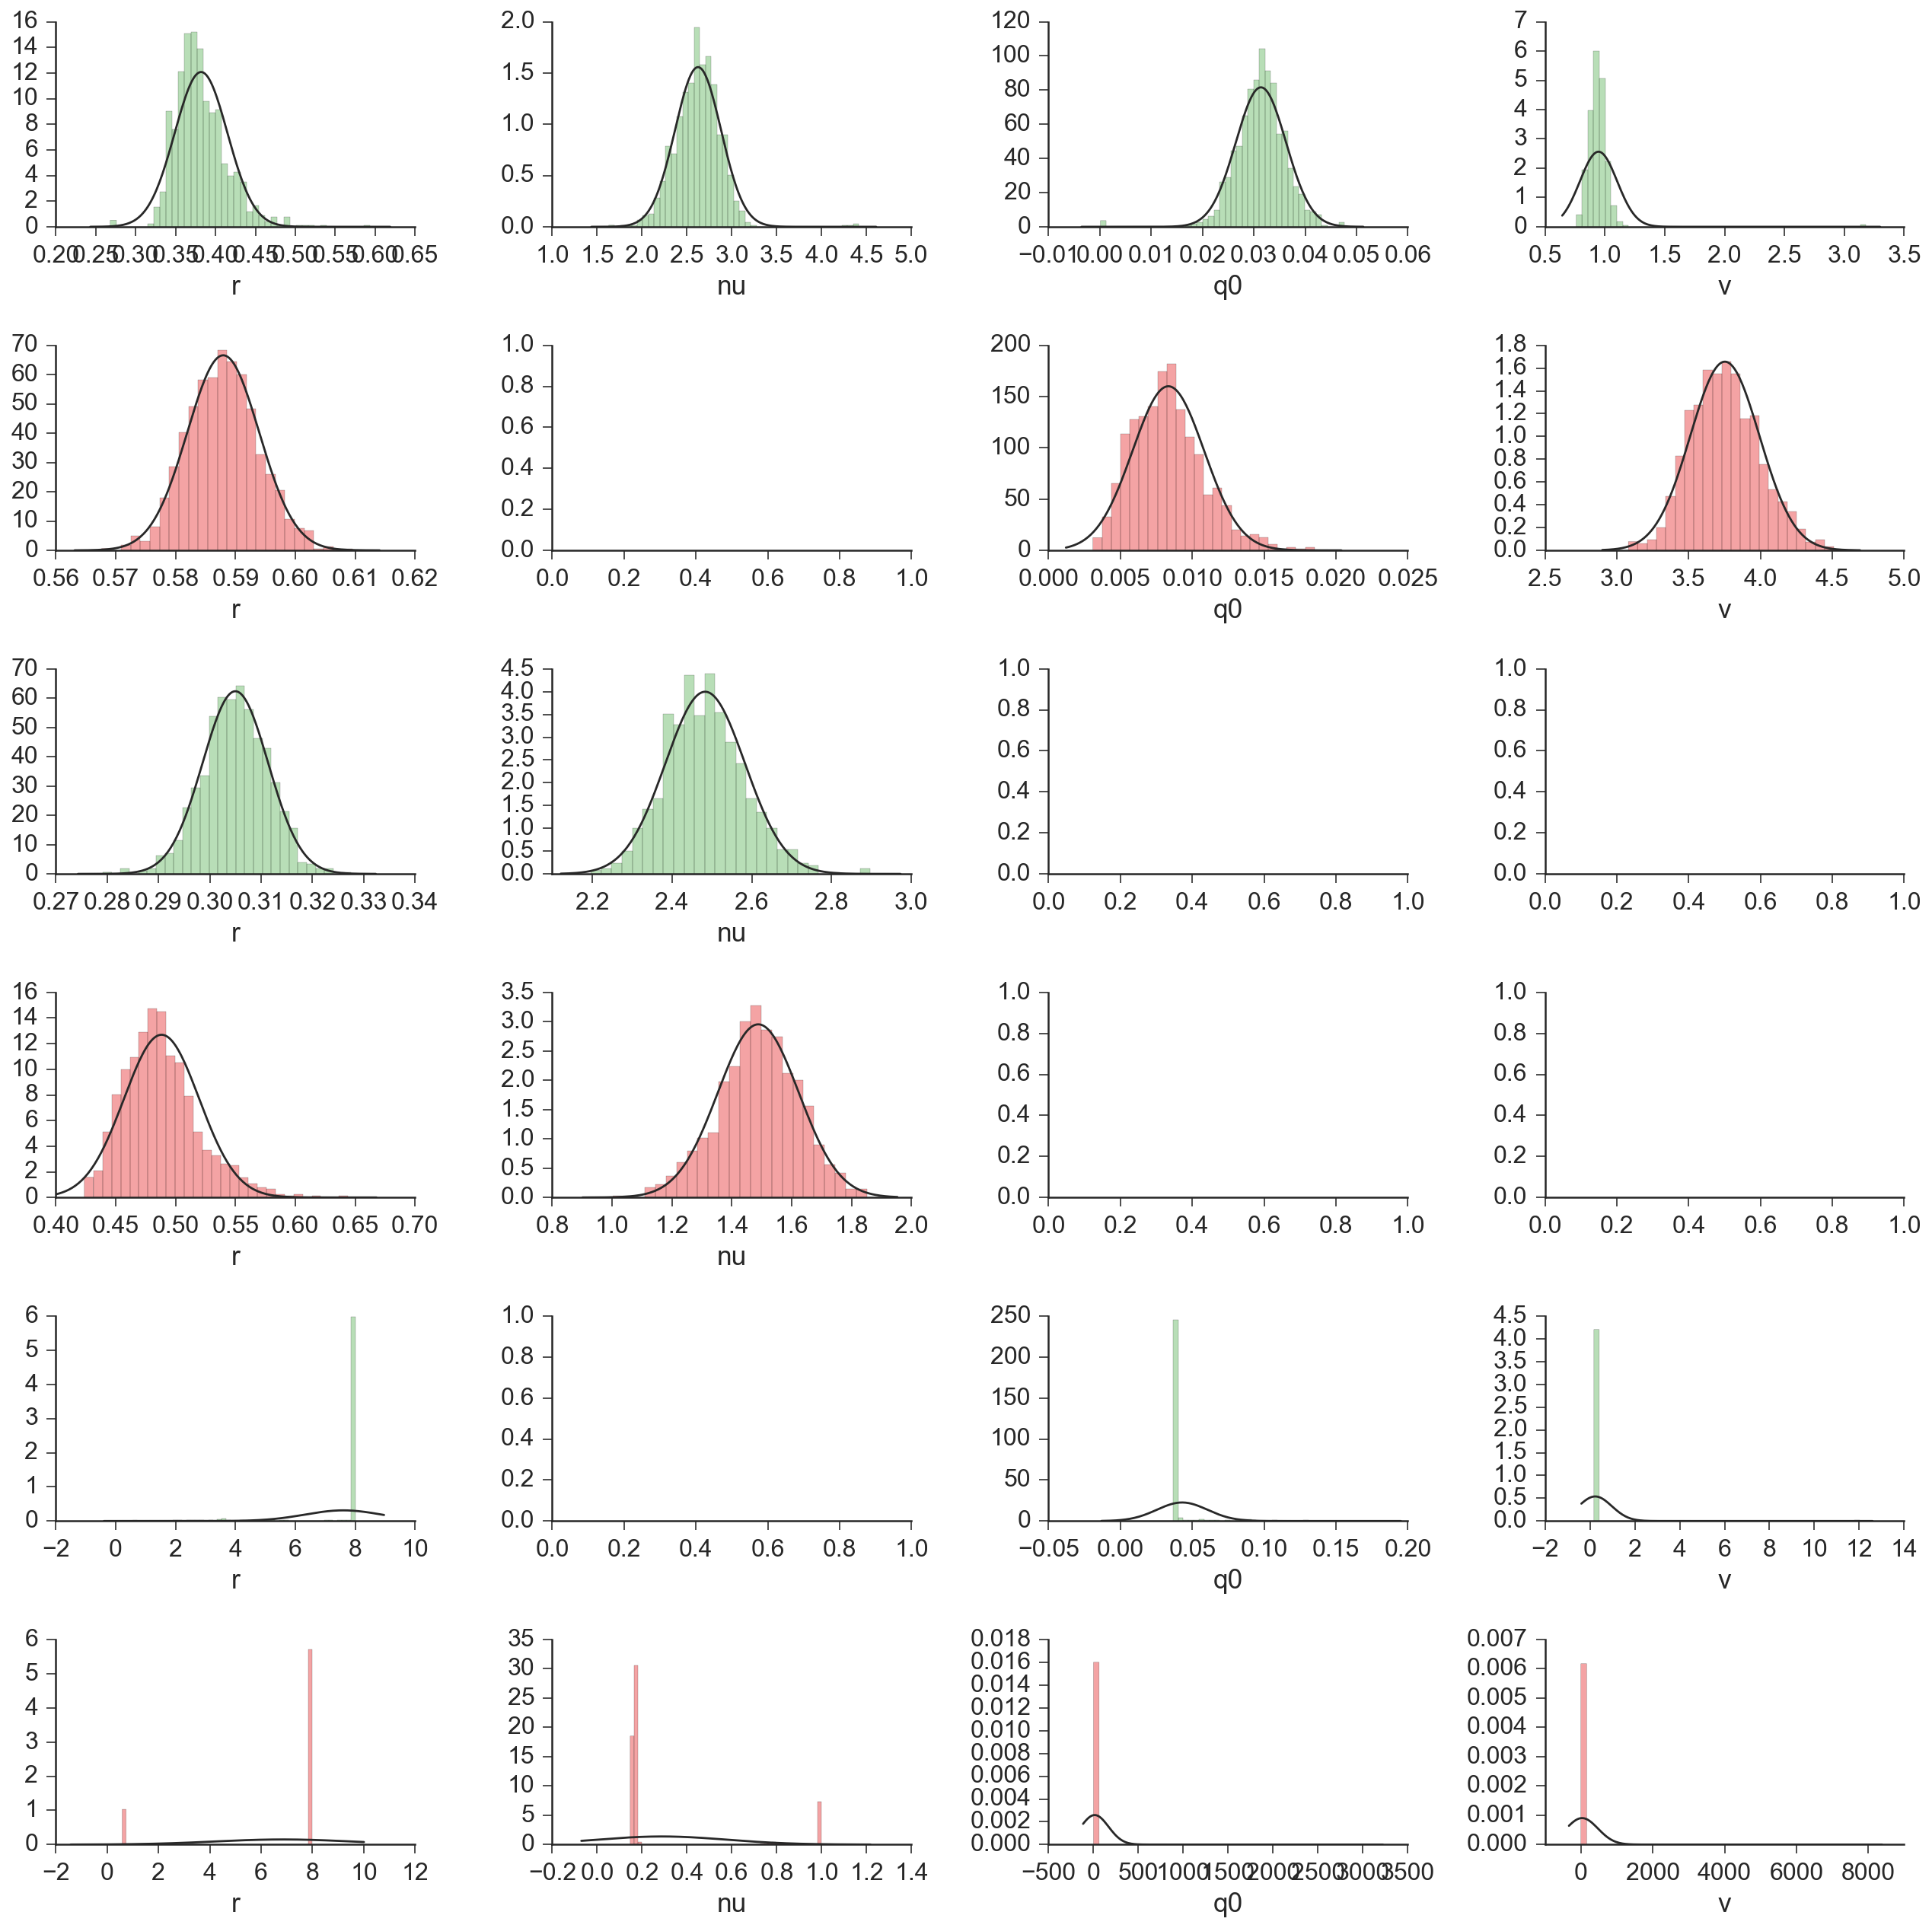

In [11]:
fig, ax = plt.subplots(len(datasets) * 2, 4, figsize=(18, 18))
for row, (name, ds) in enumerate(datasets.items()):
    for i, psam, color in zip((0, 1), (ds['param_samples_G'], ds['param_samples_R']), (green, red)):
#         sns.distplot(psam.y0, kde=False, color=color, ax=ax[2 * row + i, 0])
#         sns.distplot(psam.K, kde=False, color=color, ax=ax[2 * row + i, 1])
        sns.distplot(psam.r, kde=False, fit=norm, color=color, ax=ax[2 * row + i, 0])
        if 'nu' in psam:
            sns.distplot(psam.nu, kde=False, fit=norm, color=color, ax=ax[2 * row + i, 1])
        if np.isfinite(psam.q0).any():
            sns.distplot(psam.q0[np.isfinite(psam.q0)], kde=False, fit=norm, color=color,  ax=ax[2 * row + i, 2])
        if np.isfinite(psam.v).any():
            sns.distplot(psam.v[np.isfinite(psam.v)], kde=False, fit=norm, color=color, ax=ax[2 * row + i, 3])
fig.tight_layout()
sns.despine()

In [12]:
for name, ds in datasets.items():
    print(name)
    print('Green')
    K = ds['model_G'].best_values['K']
    low_K, high_K = curveball.models.find_K_ci(ds['param_samples_G'])
    print('* K = {:.3f} ({:.3f}, {:.3f})'.format(K, low_K, high_K))
    _, _, a, _, _, mu = curveball.models.find_max_growth(ds['model_G'])
    low_a, high_a, low_mu, high_mu = curveball.models.find_max_growth_ci(ds['model_G'], ds['param_samples_G'])
    print('* maxr = {:.3f} ({:.3f}, {:.3f}) -> {:.2f}'.format(a, low_a, high_a, np.log(2)/a))
    print('* mu = {:.3f} ({:.3f}, {:.3f}) -> {:.2f}'.format(mu, low_mu, high_mu, np.log(2)/mu))
    dbl = curveball.models.find_min_doubling_time(ds['model_G'])
    low_dbl, high_dbl = curveball.models.find_min_doubling_time_ci(ds['model_G'], ds['param_samples_G'])
    print('* dbl = {:.3f} ({:.3f}, {:.3f})'.format(dbl, low_dbl, high_dbl))
    lag = curveball.models.find_lag(ds['model_G'])
    low_lag, high_lag = curveball.models.find_lag_ci(ds['model_G'], ds['param_samples_G'])
    print('* lag = {:.3f} ({:.3f}, {:.3f})'.format(lag, low_lag, high_lag))
    
    print('Red')
    K = ds['model_R'].best_values['K']
    low_K, high_K = curveball.models.find_K_ci(ds['param_samples_R'])
    print('* K = {:.3f} ({:.3f}, {:.3f})'.format(K, low_K, high_K))
    _, _, a, _, _, mu = curveball.models.find_max_growth(ds['model_R'])
    low_a, high_a, low_mu, high_mu = curveball.models.find_max_growth_ci(ds['model_R'], ds['param_samples_R'])
    print('* maxr = {:.3f} ({:.3f}, {:.3f}) -> {:.2f}'.format(a, low_a, high_a, np.log(2)/a))
    print('* mu = {:.3f} ({:.3f}, {:.3f}) -> {:.2f}'.format(mu, low_mu, high_mu, np.log(2)/mu))
    dbl = curveball.models.find_min_doubling_time(ds['model_R'])
    low_dbl, high_dbl = curveball.models.find_min_doubling_time_ci(ds['model_R'], ds['param_samples_R'])
    print('* dbl = {:.3f} ({:.3f}, {:.3f})'.format(dbl, low_dbl, high_dbl))
    lag = curveball.models.find_lag(ds['model_R'])
    low_lag, high_lag = curveball.models.find_lag_ci(ds['model_R'], ds['param_samples_R'])
    print('* lag = {:.3f} ({:.3f}, {:.3f})'.format(lag, low_lag, high_lag))
    print()

2015-11-18
Green
* K = 0.528 (0.525, 0.532)
* maxr = 0.079 (0.077, 0.081) -> 8.80
* mu = 0.268 (0.262, 0.275) -> 2.58
* dbl = 2.695 (2.636, 2.766)
* lag = 3.931 (3.824, 4.031)
Red
* K = 0.650 (0.644, 0.658)
* maxr = 0.093 (0.091, 0.095) -> 7.47
* mu = 0.376 (0.371, 0.382) -> 1.84
* dbl = 1.844 (1.809, 1.880)
* lag = 1.578 (1.525, 1.641)

2015-12-14
Green
* K = 0.619 (0.612, 0.625)
* maxr = 0.079 (0.078, 0.080) -> 8.76
* mu = 0.256 (0.251, 0.261) -> 2.71
* dbl = 4.372 (4.276, 4.467)


/Users/yoavram/Work/Research/Lilach/curveball_project/curveball/curveball/models.py:695: UserWarning: Warning: omitting 6 negative lag values
  warn("Warning: omitting {0} negative lag values".format(len(lags) - idx.sum()))


* lag = 0.004 (0.002, 0.012)
Red
* K = 0.628 (0.624, 0.632)
* maxr = 0.095 (0.094, 0.098) -> 7.26
* mu = 0.369 (0.355, 0.386) -> 1.88
* dbl = 2.451 (2.397, 2.506)


/Users/yoavram/Work/Research/Lilach/curveball_project/curveball/curveball/models.py:695: UserWarning: Warning: omitting 28 negative lag values
  warn("Warning: omitting {0} negative lag values".format(len(lags) - idx.sum()))


* lag = 0.014 (0.002, 0.029)

2016-01-06
Green
* K = 0.633 (0.627, 0.638)
* maxr = 0.078 (0.078, 0.079) -> 8.84
* mu = 0.228 (0.226, 0.231) -> 3.04
* dbl = 3.117 (3.077, 3.156)
* lag = 0.711 (0.684, 0.753)
Red
* K = 0.741 (0.735, 0.746)
* maxr = 0.100 (0.098, 0.102) -> 6.93
* mu = 0.420 (0.392, 0.426) -> 1.65
* dbl = 2.075 (2.045, 2.124)
* lag = 0.039 (0.033, 0.082)



## Exponential model

In [13]:
from scipy.misc import derivative
from curveball.utils import smooth

ds = datasets['2015-11-18']
df = ds['dfR']
print("# wells:", len(df.Well.unique()))
df = df.groupby('Time').OD.mean().reset_index()
R = df['OD']
tR = df['Time']
R_smooth = smooth(tR, R)
dRdt = derivative(R_smooth, tR)
imax = dRdt.argmax()
tmax = tR[imax]
slopeR, interceptR = curveball.models.fit_exponential_growth_phase(tR, R)

# wells: 22


y=0.08826576014344363 * e^0.35479435465907994 t


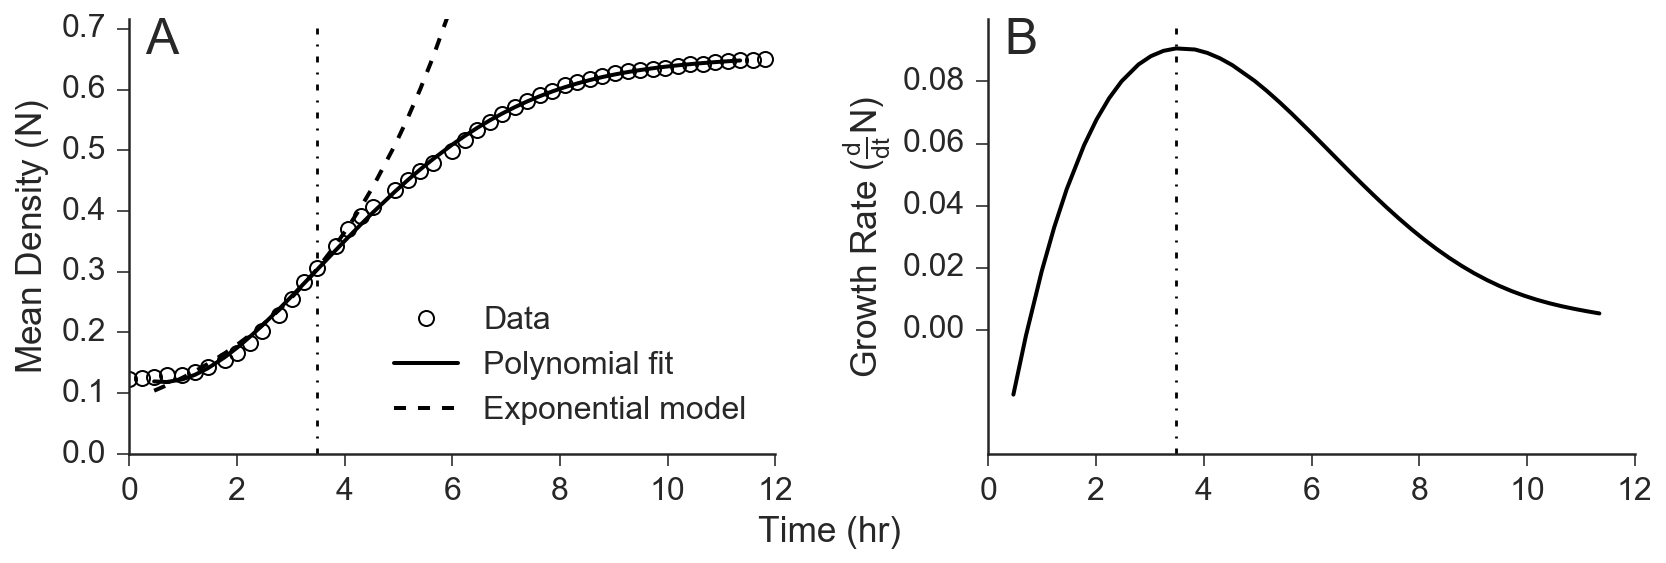

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(width * 2, height))

# slice 2:-2 because the smoothing is less credible in the ends
ax[0].plot(tR, R, 'o', markerfacecolor='None', markeredgewidth=1, markeredgecolor='k', label='Data')
ax[0].plot(tR[2:-2], R_smooth(tR[2:-2]), '-', lw=2, color='k', label='Polynomial fit')
ax[1].plot(tR[2:-2], dRdt[2:-2], color='k', lw=2)
ax[0].plot(tR[2:-2], np.exp(interceptR + tR * slopeR)[2:-2], color='k', ls=pred_ls, lw=2, label='Exponential model')
print('y={N0} * e^{r} t'.format(r=slopeR, N0=np.exp(interceptR)))
ax[0].axvline(tmax, color='k', ls='-.')
ax[1].axvline(tmax, color='k', ls='-.')

ax[0].set_ylabel(r'Mean Density ($N$)')
ax[0].set_ylim(0, 1.1 * R.max())
ax[0].legend(loc='lower right')

ax[1].set_ylabel(r'Growth Rate $(\frac{d}{dt}N)$')
ax[1].set_yticks([0, 0.02, 0.04, 0.06, 0.08])

fig_xlabel(fig, 'Time (hr)')
fig_panel_labels(ax, xcoord=0.025, panel_label_size=panel_label_size)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-exponential_model-explained.png')
fig.savefig('Fig-exponential_model-explained.pdf', dpi=300)

In [16]:
def exponential_model(mGreen, mRed, frac_green=0.3, frac_red=0.3, di=2, 
                     colors=sns.color_palette('Set1', 3)[::2], ax=None, PLOT=False):
    G = np.unique(mGreen.best_fit)
    tG = np.unique(mGreen.userkws['t'])
    
    R = np.unique(mRed.best_fit)
    tR = np.unique(mRed.userkws['t'])
    
    slopeG, interceptG = curveball.models.fit_exponential_growth_phase(tG, G)
    slopeR, interceptR = curveball.models.fit_exponential_growth_phase(tR, R)    

    if PLOT:
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        ax.plot(tG, G, color=colors[1])
        ax.plot(tG, np.exp(slopeG * tG + interceptG), '--', color=colors[1])
        ax.plot(tR, R, color=colors[0])
        ax.plot(tR, np.exp(slopeR * tR + interceptR), '--', color=colors[0])

        ax.set(ylim=(0.9*min(G.min(), R.min()), 1.1*max(G.max(), R.max())), xlabel='Time (hour)', ylabel='log OD', yscale='log')        
        fig.tight_layout()
        sns.despine()
        return slopeG, interceptG, slopeR, interceptR, fig, ax 
    return slopeG, interceptG, slopeR, interceptR

2015-11-18 r_G=0.268, r_R=0.302
2015-12-14 r_G=0.229, r_R=0.298
2016-01-06 r_G=0.201, r_R=0.307


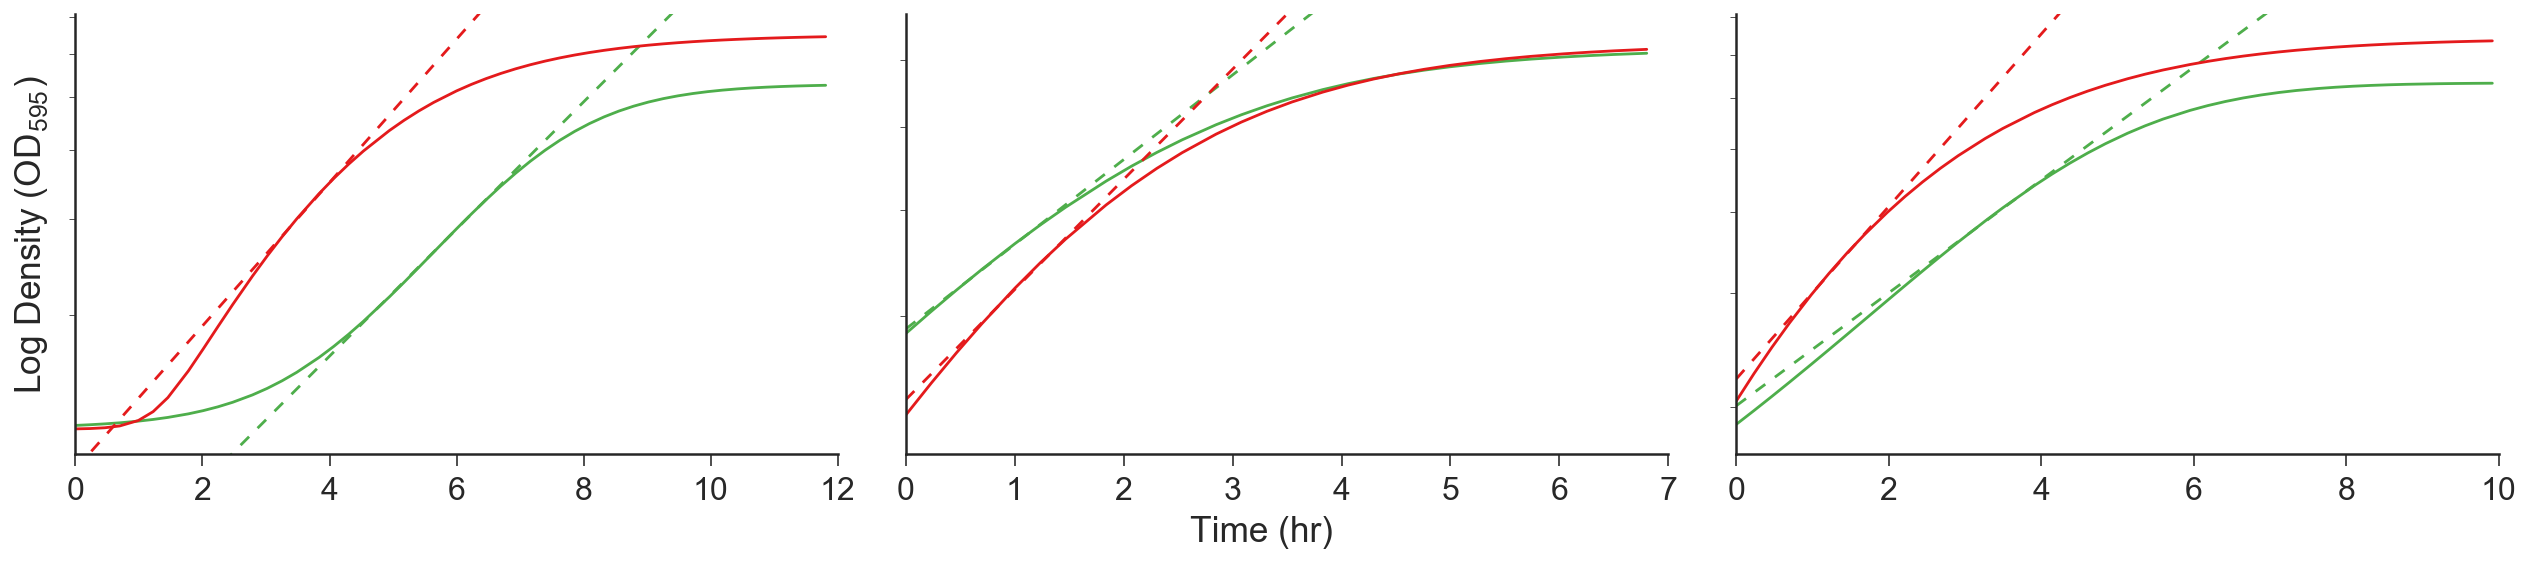

In [17]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=False, figsize=(width * cols, height))
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
for i,(name, ds) in enumerate(datasets.items()):
    ds['slopeG'], ds['interceptG'], ds['slopeR'], ds['interceptR'], _, _  = exponential_model(ds['model_G'], ds['model_R'], ax=ax[i], PLOT=True)    
    print(name, 'r_G={:.3g}, r_R={:.3g}'.format(ds['slopeG'], ds['slopeR']))
    ax[i].set(title='', xlabel='', yticks=[])
    if i == 0:
        ax[i].set(ylabel=r'Log Density ($OD_{595}$)')
    else:
        ax[i].set(ylabel='')
fig_xlabel(fig, 'Time (hr)')
fig.tight_layout()
sns.despine()
# fig.savefig('Fig-exponential_model.png')
# fig.savefig('Fig-exponential_model.pdf', dpi=300)

## Competition prediction

In [18]:
for ds in datasets.values():
    ds['flow_summary_df'] = pd.read_csv(ds['flow_summary_file'])

In [19]:
ode = curveball.competitions.baranyi_roberts_yr

for name, ds in datasets.items():
    print(name, end=" ")
    K = ds['model_G'].best_values['K'], ds['model_R'].best_values['K']
    r = ds['model_G'].best_values['r'], ds['model_R'].best_values['r']
    nu = ds['model_G'].best_values.get('nu',1), ds['model_R'].best_values.get('nu',1)
    q0 = ds['model_G'].best_values.get('q0', np.inf), ds['model_R'].best_values.get('q0', np.inf)
    v = ds['model_G'].best_values.get('v', r[0]), ds['model_R'].best_values.get('v', r[1])
    y0 = ds['model_G'].best_values['y0']/2, ds['model_R'].best_values['y0']/2

    f0 = np.array(ds['flow_summary_df'][ds['flow_summary_df'].time==ds['flow_summary_df'].time.min()].freq_mean) # initial frequencies from flow data
    RG_model_min = np.unique(ds['model_RG'].best_fit).min() # expected initial mixed culture OD from mixed culture model
    RG_mean = ds['dfRG'].groupby('Time').OD.mean().as_matrix()
    RG_std = ds['dfRG'].groupby('Time').OD.std().as_matrix()
    RG_t = np.unique(ds['dfRG'].Time)
    G0, R0 = f0 * RG_model_min # expected initial OD of each strain in mixed culture
    ds['G0'] = G0
    ds['R0'] = R0
    
    t, y, a = curveball.competitions.fit_and_compete(
        ds['model_G'], 
        ds['model_R'], 
        ds['dfRG'],
        ode=ode,
        y0=(G0, R0),
        aguess=(1,1),
        PLOT=False,
        fixed=False
    )
    MRSE = ((odeint(ode, (G0, R0), RG_t, args=(K, r, nu, q0, v, a)).sum(axis=1) - RG_mean)**2).mean()
    
    t_fixed, y_fixed, _ = curveball.competitions.fit_and_compete(
        ds['model_G'], 
        ds['model_R'], 
        ds['dfRG'],
        ode=ode,
        y0=(G0, R0),
        aguess=(1,1),
        PLOT=False,
        fixed=True
    )
    
    ds['a'] = a
    ds['RG_model_min'] = RG_model_min
    ds['RG_mean'] = RG_mean
    ds['RG_std'] = RG_std
    ds['RG_t'] = RG_t
    ds['predicted_t'] = t
    ds['predicted_y'] = y
    ds['predicted_t_fixed'] = t_fixed
    ds['predicted_y_fixed'] = y_fixed
    ds['MRSE'] = MRSE
 
    # exponential model
    slopeG = ds['slopeG']
    slopeR = ds['slopeR']
    Nexp = G0*np.exp(slopeG * t), R0*np.exp(slopeR * t)
    ds['Gexp'] = Nexp[0] 
    ds['Rexp'] = Nexp[1] 
    ds['Bexp'] = Nexp[0] + Nexp[1]
    ds['pGexp'] = Nexp[0]/ds['Bexp']
    ds['pRexp'] = Nexp[1]/ds['Bexp']

2015-11-18 2015-12-14 2016-01-06 

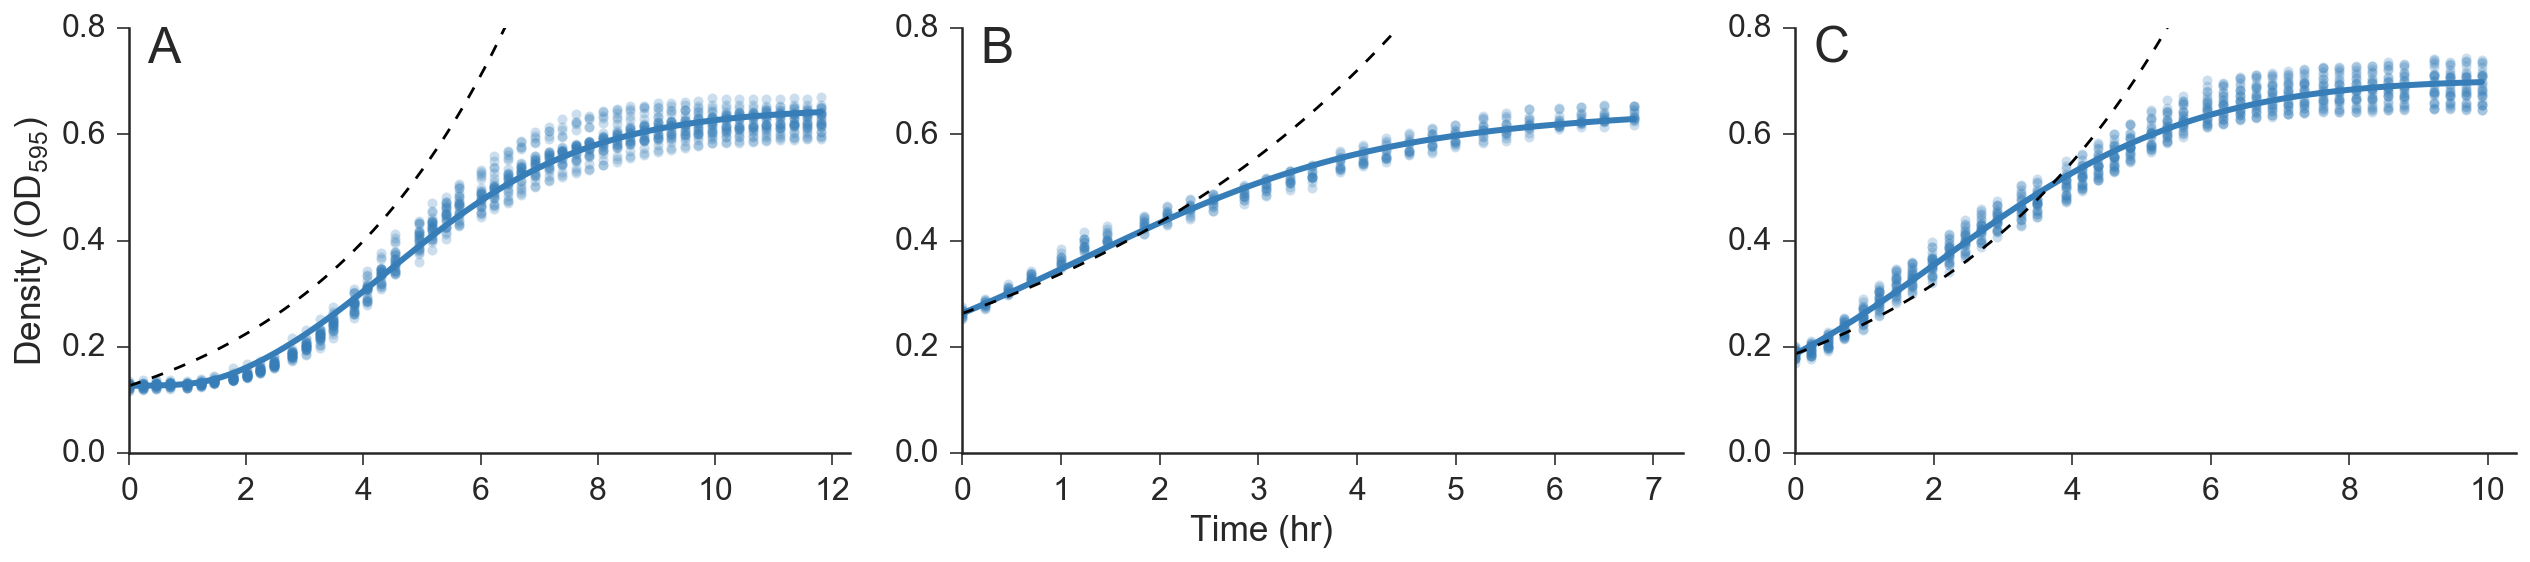

In [20]:
rows = 1
cols = len(datasets)

fig, ax = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=(width * cols, height * rows))
ax.resize((rows, cols))
for col,(name, ds) in enumerate(datasets.items()):
    if col >= cols:
        break
   
    RG_mean = ds['RG_mean']
    RG_std = ds['RG_std']
    RG_t = ds['RG_t']
    t = ds['predicted_t']
    y = ds['predicted_y']
    MRSE = ds['MRSE']
    t_fixed = ds['predicted_t_fixed']
    y_fixed = ds['predicted_y_fixed']    
    flow_df = ds['flow_summary_df']
    
    ysum = y.sum(axis=1)
    ysum_fixed = y_fixed.sum(axis=1)
    p1 = y[:, 0] / ysum
    p2 = y[:, 1] / ysum
    p1_fixed = y_fixed[:, 0] / ysum_fixed
    p2_fixed = y_fixed[:, 1] / ysum_fixed
    
    # comp model fit
    ax[0, col].plot(t, ysum, color=blue, ls=fit_ls, lw=3)

    # OD data
    ds['dfRG'].plot('Time', 'OD', ax=ax[0, col], color=blue, alpha=0.25, marker='o', markersize=5, ls='')
#     ax[0, col].errorbar(RG_t, RG_mean, RG_std, fmt='^', color=blue, alpha=0.7)
    
#     ax[0, col].annotate('{0}1+{0}2'.format('ABC'[col]), (RG_t.max()-1.75, RG_mean.max()-0.15), 
#                       xycoords='data', color=blue)


    # exponential model
    ax[0, col].plot(t, ds['Bexp'], color='k', ls=pred_ls) # exponential model        

    
    ax[0, col].set(
        xlabel='',
        ylabel='',
        xlim=(0, t.max() + 0.5),
        title="",
    )
    if 'ylim' in ds:
        ax[0, col].set_ylim(ds['ylim'])
        dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
        ax[0, col].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))
    ax[0,col].legend().set_visible(False)
ax[0,0].set_ylabel(r'Density ($OD_{595}$)')
fig_xlabel(fig, 'Time (hr)')
fig_panel_labels(ax, xcoord=0.025, panel_label_size=panel_label_size)
    
sns.despine()
fig.tight_layout()
fig.savefig('Fig-Competition_fitting.png')
fig.savefig('Fig-Competition_fitting.pdf', dpi=300)

2015-11-18 RMSE : 0.011 a1=10, a2=0.77
2015-12-14 RMSE : 0.01 a1=3.7, a2=1.9
2016-01-06 RMSE : 0.0082 a1=0.31, a2=0.56


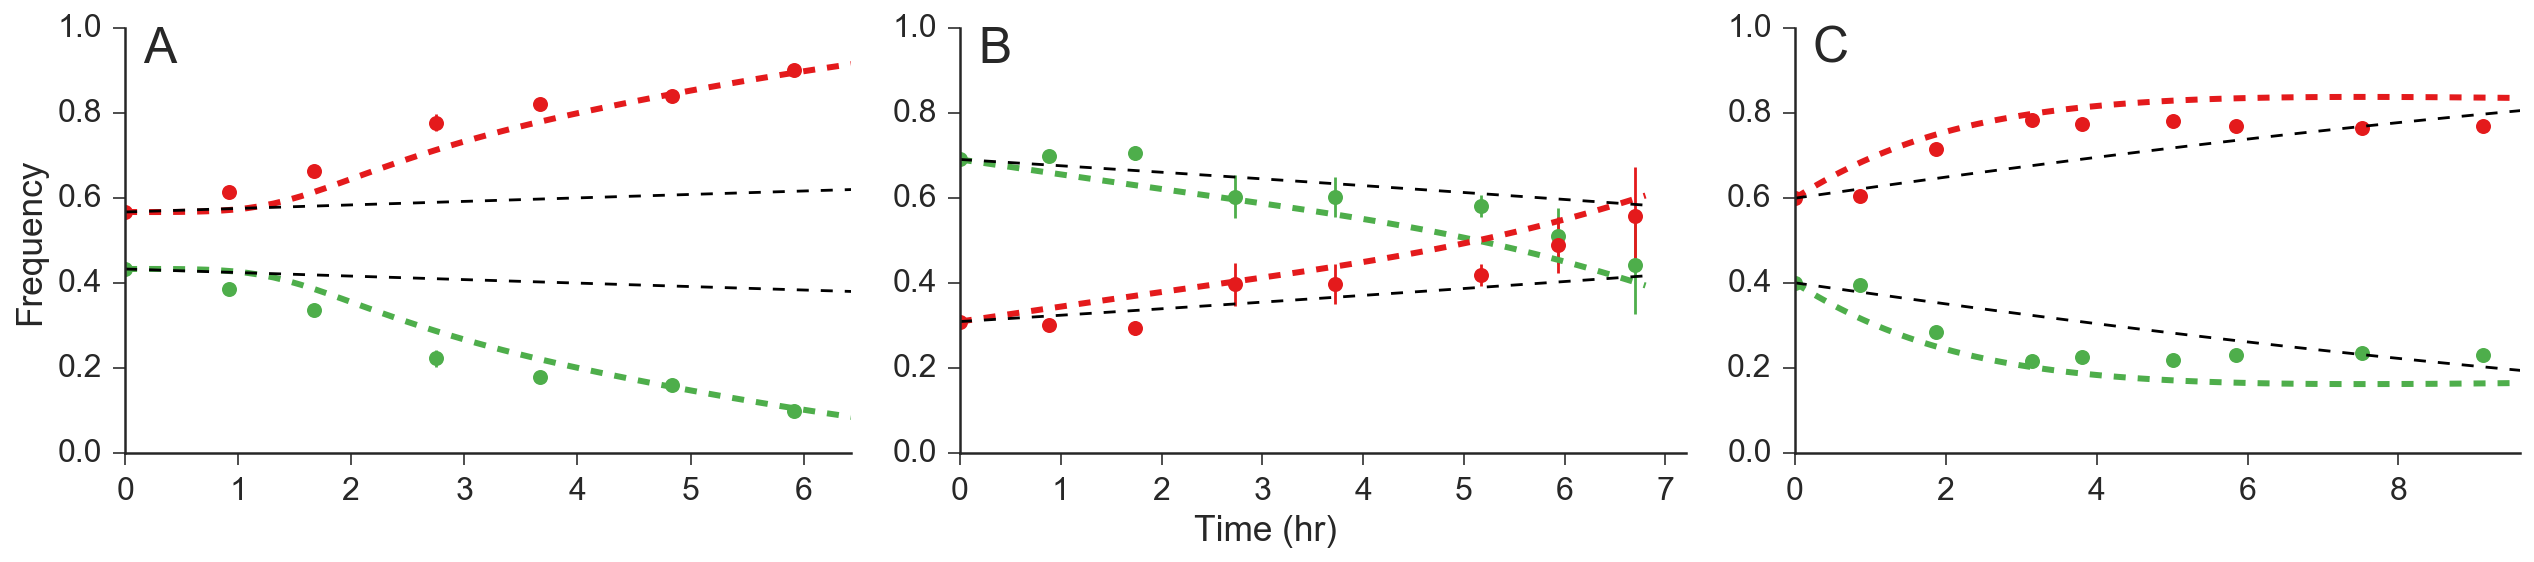

In [21]:
rows = 1
cols = len(datasets)

fig, ax = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=(width * cols, height * rows))
ax.resize((rows, cols))
for col,(name, ds) in enumerate(datasets.items()):
    if col >= cols:
        break
   
    RG_mean = ds['RG_mean']
    RG_std = ds['RG_std']
    RG_t = ds['RG_t']
    t = ds['predicted_t']
    y = ds['predicted_y']
    MRSE = ds['MRSE']
    t_fixed = ds['predicted_t_fixed']
    y_fixed = ds['predicted_y_fixed']    
    flow_df = ds['flow_summary_df']
    
    ysum = y.sum(axis=1)
    ysum_fixed = y_fixed.sum(axis=1)
    p1 = y[:, 0] / ysum
    p2 = y[:, 1] / ysum
    p1_fixed = y_fixed[:, 0] / ysum_fixed
    p2_fixed = y_fixed[:, 1] / ysum_fixed
    
    ### TOP PANELS
    # comp model fit
#     ax[0, col].plot(t, ysum, color=blue, ls=fit_ls)

#     # OD data
#     ax[0, col].errorbar(RG_t, RG_mean, RG_std, fmt='^', color=blue, alpha=0.7)
    
#     # exponential model
#     ax[0, col].plot(t, ds['Bexp'], color='k', ls=pred_ls) # exponential model        
    
#     ax[0, col].set(
#         ylabel=r'Density ($OD_{595}$)', 
#         xlim=(0, t.max() + 0.5),
#         title="",
#     )
#     if 'ylim' in ds:
#         ax[0, col].set_ylim(ds['ylim'])
#         dy = (ds['ylim'][1] - ds['ylim'][0]) / 4
#         ax[0, col].set_yticks(np.arange(ds['ylim'][0], ds['ylim'][1] + dy, dy))

    ### BOTTOM PANELS
    ###
    # prediction based on comp model fit
    ax[0, col].plot(t, p1, color=green, ls=pred_ls, lw=3)
    ax[0, col].plot(t, p2, color=red, ls=pred_ls, lw=3)

    # flow data
    idx = ds['flow_summary_df'].Strain == 'Green'
    ax[0, col].errorbar(
        ds['flow_summary_df'][idx].time, 
        ds['flow_summary_df'][idx].freq_mean.as_matrix(), 
        ds['flow_summary_df'][idx].freq_std.as_matrix(), 
        marker='o', 
        ls='', 
        color=green
    )
    idx = ds['flow_summary_df'].Strain == 'Red'
    ax[0, col].errorbar(
        ds['flow_summary_df'][idx].time, 
        ds['flow_summary_df'][idx].freq_mean.as_matrix(), 
        ds['flow_summary_df'][idx].freq_std.as_matrix(), 
        marker='o',
        ls='', 
        color=red
    )
    # exponential model
    ax[0, col].plot(t, ds['pGexp'], color='k', ls=pred_ls)
    ax[0, col].plot(t, ds['pRexp'], color='k', ls=pred_ls)
#     ###
    
    ax[0, col].set(
        ylabel='',        
        xlim=(0, ds['flow_summary_df'][idx].time.max() + 0.5),
        ylim=(0, 1),
        title="",
        xlabel="",
        yticks=np.linspace(0, 1.0, 6),
        
    )
    
    print(name, "RMSE : {:.2g}".format(np.sqrt(MRSE)), "a1={:.2g}, a2={:.2g}".format(*ds['a'])) 
ax[0,0].set_ylabel('Frequency')
fig_xlabel(fig, 'Time (hr)')
fig_panel_labels(ax, xcoord=0.025, panel_label_size=panel_label_size)
    
sns.despine()
fig.tight_layout()
fig.savefig('Fig-Competition_prediction.png')
fig.savefig('Fig-Competition_prediction.pdf', dpi=300)

### Prediction confidence interval

2015-11-18
Green: 8.421 < 9.901 < 10.000
Red: 0.620 < 0.760 < 0.891

2015-12-14
Green: 3.008 < 3.758 < 5.046
Red: 1.241 < 1.895 < 2.555

2016-01-06
Green: 0.299 < 0.400 < 0.915
Red: 0.508 < 0.635 < 1.109



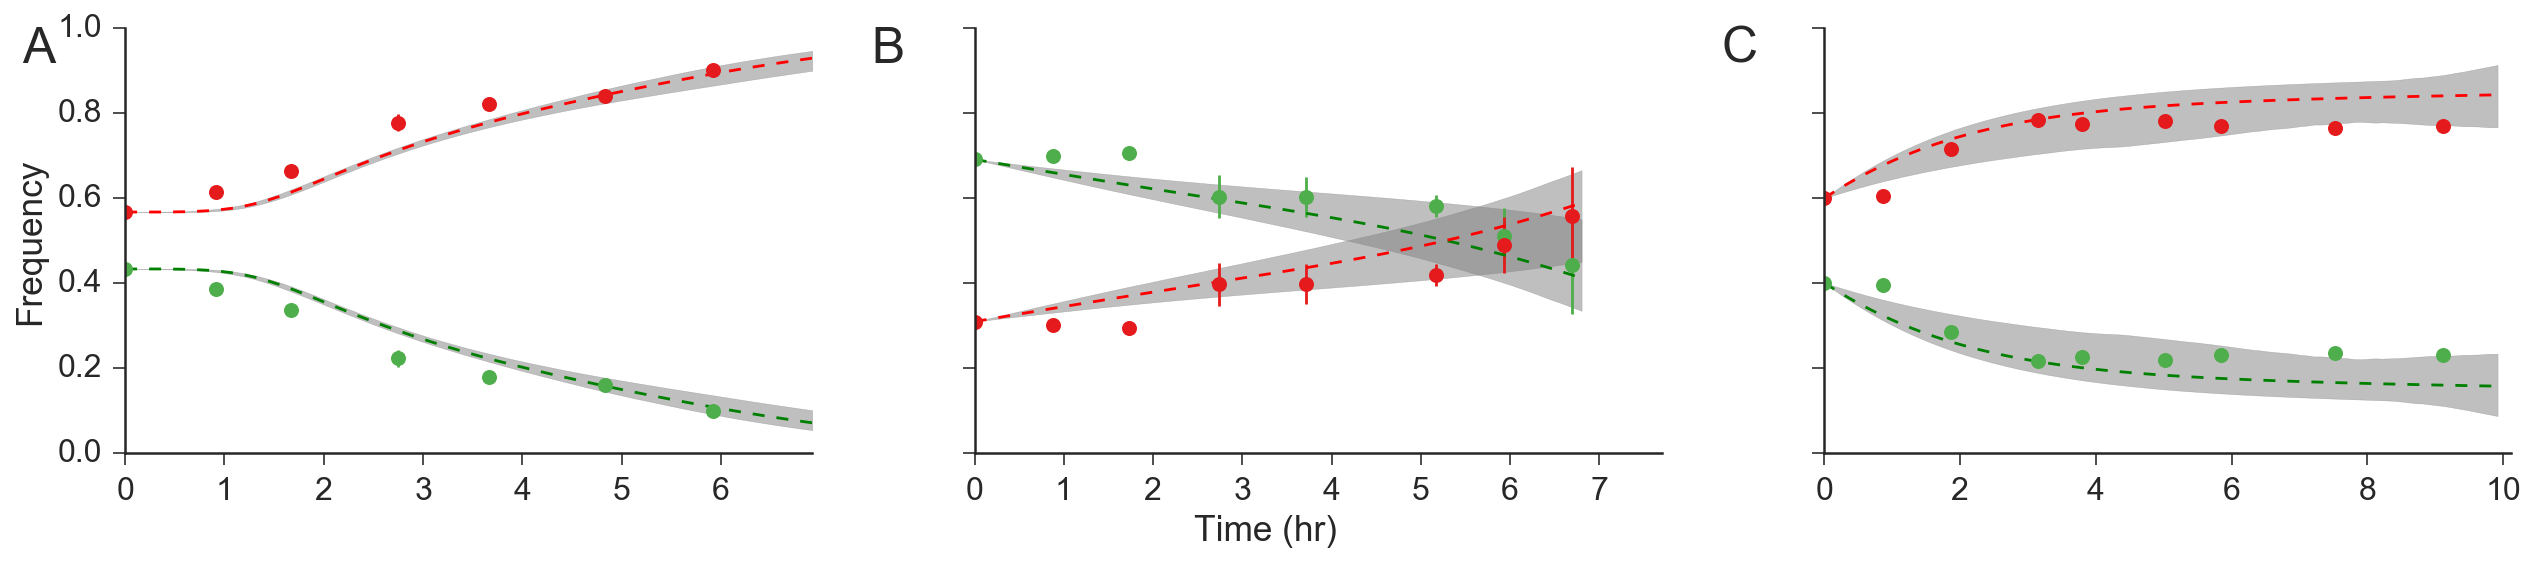

In [22]:
cols = len(datasets)
rows = 1
fig, ax = plt.subplots(rows, cols, sharex=False, sharey=True, figsize=(width * cols, height * rows))
for col,(name, ds) in enumerate(datasets.items()):
    # prediction with CI
    low_a, avg_a, high_a, low_f, avg_f, high_f, _, _ = curveball.competitions.fit_and_compete_ci(
        ds['param_samples_G'],
        ds['param_samples_R'],
        ds['dfRG'],
        y0=(ds['G0'], ds['R0']),
        ci=0.95,
        ax=ax[col],
        PLOT=True, 
        line_kws=dict(ls='--')
    )
    # flow data
    idx = ds['flow_summary_df'].Strain == 'Green'
    ax[col].errorbar(
        ds['flow_summary_df'][idx].time, 
        ds['flow_summary_df'][idx].freq_mean.as_matrix(), 
        ds['flow_summary_df'][idx].freq_std.as_matrix(), 
        marker='o', 
        ls='', 
        color=green
    )
    idx = ds['flow_summary_df'].Strain == 'Red'
    ax[col].errorbar(
        ds['flow_summary_df'][idx].time, 
        ds['flow_summary_df'][idx].freq_mean.as_matrix(), 
        ds['flow_summary_df'][idx].freq_std.as_matrix(), 
        marker='o',
        ls='', 
        color=red
    )
    ax[col].set_xlabel('')
    if col > 0: 
        ax[col].set_ylabel('')
    ax[col].set_xlim(0, ds['flow_summary_df'].time.max() + 1)
    
    print("{}\nGreen: {:.3f} < {:.3f} < {:.3f}\nRed: {:.3f} < {:.3f} < {:.3f}\n".format(
            name,
            low_a[0],
            avg_a[0],
            high_a[0],
            low_a[1],
            avg_a[1],
            high_a[1]
    ))
    
fig_xlabel(fig, 'Time (hr)')
fig_panel_labels(ax, xcoord=-0.15)
    
sns.despine()
fig.tight_layout(w_pad=4)
fig.savefig('Fig-Competition_prediction_ci.png')
fig.savefig('Fig-Competition_prediction_ci.pdf', dpi=300)

## Relative fitness prediction in lacI

In [8]:
kws = dict(
    marker='o',
    markeredgewidth=1, 
    markeredgecolor='k',
    color='k',
    ecolor='k',
    capsize=0,
    elinewidth=0.5,
    ls='',
)

In [4]:
df1 = pd.DataFrame({'estimate': {0: 0.95348837200000003,   1: 1.0062015499999999,   2: 0.91782945700000007,   3: 0.87829457400000011,   4: 0.79612403099999995,   5: 0.99922480599999997,   6: 0.97829457400000008,   7: 0.92248061999999997,   8: 0.96511627900000008,   9: 1.020155039,   10: 0.94108527099999995,   11: 0.85426356599999997,   12: 0.75658914700000002,   13: 0.9635658909999999,   14: 0.97829457400000008,   15: 0.94496124000000004},  'high': {0: 0.993726938,   1: 1.0277359580000001,   2: 0.95893908599999989,   3: 0.93998749500000001,   4: 0.84938331400000011,   5: 1.0264379029999999,   6: 0.99917876599999988,   7: 0.9449201009999999,   8: 1.0235821840000001,   9: 1.0472067700000001,   10: 0.957900643,   11: 0.86729646199999999,   12: 0.77435578299999996,   13: 0.98827511099999998,   14: 1.0015152629999999,   15: 0.96620819000000002},  'low': {0: 0.8841711659999999,   1: 0.98334250499999998,   2: 0.87560400799999993,   3: 0.81407624099999998,   4: 0.739827542,   5: 0.97191962799999998,   6: 0.95608336700000007,   7: 0.90104587000000003,   8: 0.93583372200000003,   9: 0.99294810599999994,   10: 0.92389162400000002,   11: 0.84029693500000002,   12: 0.74008715299999994,   13: 0.93894905200000001,   14: 0.95504492400000007,   15: 0.92389162400000002},  'source': {0: 'data',   1: 'data',   2: 'data',   3: 'data',   4: 'data',   5: 'data',   6: 'data',   7: 'data',   8: 'model',   9: 'model',   10: 'model',   11: 'model',   12: 'model',   13: 'model',   14: 'model',   15: 'model'},  'strain': {0: 'Lac5',   1: 'GL2',   2: 'GL5',   3: 'GL6',   4: 'LG1',   5: 'LG2',   6: 'LG4',   7: 'LG5',   8: 'Lac5',   9: 'GL2',   10: 'GL5',   11: 'GL6',   12: 'LG1',   13: 'LG2',   14: 'LG4',   15: 'LG5'}})
df1.head()

,estimate,high,low,source,strain
0,0.953488,0.993727,0.884171,data,Lac5
1,1.006202,1.027736,0.983343,data,GL2
2,0.917829,0.958939,0.875604,data,GL5
3,0.878295,0.939987,0.814076,data,GL6
4,0.796124,0.849383,0.739828,data,LG1


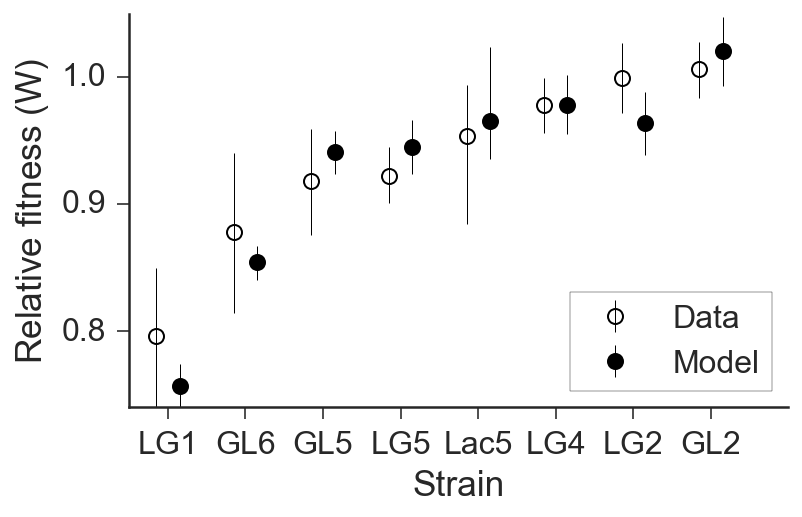

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

_df = df1[df1['source']=='data']
sort_idx = _df['estimate'].argsort().values
_df = _df.iloc[sort_idx]
ax.errorbar(
    np.arange(8)-0.15,
    _df['estimate'],
    [_df['estimate']-_df['low'], _df['high']-_df['estimate']],
    markerfacecolor='None',
    label='Data',
    **kws
)

_df = df1[df1['source']=='model']
_df = _df.iloc[sort_idx]
ax.errorbar(
    np.arange(8) + 0.15,
    _df['estimate'],
    [_df['estimate']-_df['low'], _df['high']-_df['estimate']],
    label='Model',
    **kws
)

ax.set(xlim=(-0.5, 8),
       xticks=np.arange(8),
       xticklabels=_df['strain'],
       yticks=[0.8, 0.9, 1],
       ylim=(0.74, 1.05),
       xlabel='Strain',
       ylabel='Relative fitness ($W$)'
)
ax.legend(loc='lower right', frameon=True)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-LacI_Fitness.png')
fig.savefig('Fig-LacI_Fitness.pdf', dpi=300)

In [5]:
df2 = pd.DataFrame(
    {'relative fitness cost': 
     {0: 0.002564588, 1: 0.002564588, 2: 0.002564588, 3: 0.025703685, 4: 0.128008661, 5: 0.230318892, 6: 0.20952891500000001, 7: 0.30358832099999999, 8: 0.39765298200000004, 9: 0.34064345899999998, 10: 0.44130878100000004, 11: 0.54196884700000003, 12: 0.440446911, 13: 0.54111223200000003, 14: 0.64176704299999998, 15: 0.38665888900000001, 16: 0.441114334, 17: 0.497219945, 18: 0.38372117500000003, 19: 0.47613567100000004, 20: 0.561928486}, 
     'relative expression': 
     {0: 0.003184713, 1: 0.003184713, 2: 0.003184713, 3: 0.022292994, 4: 0.022292994, 5: 0.022292994, 6: 0.42356687900000001, 7: 0.42356687900000001, 8: 0.42356687900000001, 9: 0.88216560499999996, 10: 0.88216560499999996, 11: 0.88216560499999996, 12: 1.3598726109999999, 13: 1.3598726109999999, 14: 1.3598726109999999, 15: 1.7643312099999999, 16: 1.7643312099999999, 17: 1.7643312099999999, 18: 1.984076433, 19: 1.984076433, 20: 1.984076433}, 
     'marker': 
     {0: 'low', 1: 'mid', 2: 'high', 3: 'low', 4: 'mid', 5: 'high', 6: 'low', 7: 'mid', 8: 'high', 9: 'low', 10: 'mid', 11: 'high', 12: 'low', 13: 'mid', 14: 'high', 15: 'low', 16: 'mid', 17: 'high', 18: 'low', 19: 'mid', 20: 'high'}})
df2.head()

,marker,relative expression,relative fitness cost
0,low,0.003185,0.002565
1,mid,0.003185,0.002565
2,high,0.003185,0.002565
3,low,0.022293,0.025704
4,mid,0.022293,0.128009


In [16]:
x = df2['relative expression'].unique()
# 1-s = W: convert from fitness cost / selection coefficient to relative fitness
low = 1 - df2.loc[df2['marker']=='low', 'relative fitness cost'].values
mid = 1 - df2.loc[df2['marker']=='mid', 'relative fitness cost'].values
high = 1 - df2.loc[df2['marker']=='high', 'relative fitness cost'].values

def logarithmic(x, a, b):
    return a*np.log(b*x)

par, _ = curve_fit(logarithmic, x, mid, (1,1))

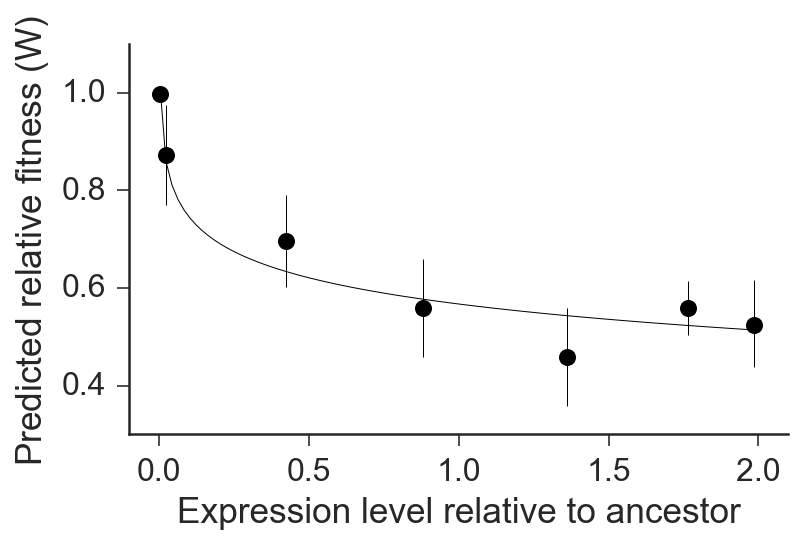

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(width, height))

ax.errorbar(
    x,
    mid,
    [mid-low, high-mid],
#     markerfacecolor='None',
    **kws
)

x_ = np.linspace(x.min(), x.max(), 100)
ax.plot(x_, logarithmic(x_, *par), '-k', lw=0.5)

ax.set(
    xlim=(-0.1, 2.1),
    ylim=(None, 1.1),
    yticks=np.arange(0.4, 1.1, 0.2),
    xlabel='Expression level relative to ancestor',
    ylabel='Predicted relative fitness ($W$)'
)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-LacI_Expression.png')
fig.savefig('Fig-LacI_Expression.pdf', dpi=300)

## Frequency-dependent selection simulations

Adjusting eqs. A1 in Chevin L-M, Biol Lett 2011 for our model parameters:

$$
\frac{dN_i}{dt} = N_i r_i \Big(1 - \frac{N_1 + N_2}{K_i} \Big) + \gamma_i \frac{N_1 N_2}{N_1 + N_2}
$$
where $\gamma_i$ are the direct interaction parameters such that setting $\gamma_i=0$ gives us the standard logistic model. 
This models competition  ($\gamma_1 < 0$ and $\gamma_2 < 0$), mutualism ($\gamma_1 > 0$ and $\gamma_2 > 0$), or exploitation ( $\gamma_1 \gamma_2 < 0$).

In [126]:
def chevin_yr_ode(y, t, *args):
    y1, y2 = y
    K, r, ν, c, γ = args
    r1, r2 = r
    K1, K2 = K
    ν1, ν2 = ν
    c1, c2 = c
    γ1, γ2 = γ

    dy1dt = r1 * y1 * (1 - (y1**ν1) / (K1**ν1) - c2 * (y2**ν2) / (K1**ν1)) + γ1 * (y1 * y2) / (y1 + y2)
    dy2dt = r2 * y2 * (1 - c1 * (y1**ν1) / (K2**ν2) - (y2**ν2) / (K2**ν2)) + γ2 * (y1 * y2) / (y1 + y2)
    
    return [dy1dt, dy2dt]

In [245]:
y0 = 0.12
K = 0.528, 0.65
r = 0.376, 0.587
ν = 2.63, 1
c = 1, 1

γ_0 = 0, 0 # no freq-dep
γ_ = 1
γ_a = -γ_/2, -γ_/2 # competition
γ_b = γ_/2, γ_/2 # mutualism
γ_c = γ_, -γ_ # exploitation 1
γ_d = -γ_, γ_ # exploitation 2
γs = (γ_a, γ_b, γ_c, γ_d)
titles = ('competition', 'cooperation', 'exploitation (G>R)', 'exploitation (R>G)')
hrs = 10
t = np.linspace(0, hrs, hrs*4)

In [201]:
ode = curveball.competitions.baranyi_roberts_yr

cache = {}
# mono-culture growth
y1 = odeint(chevin_ode, (2*y0, 0), t, args=(K, r, ν, c, γ_0))
y2 = odeint(chevin_ode, (0, 2*y0), t, args=(K, r, ν, c, γ_0))
df1 = pd.DataFrame(dict(Time=t, OD=y1[:,0]))
df2 = pd.DataFrame(dict(Time=t, OD=y2[:,1]))
model1 = curveball.models.fit_model(df1, PRINT=False, PLOT=False)[0]
model2 = curveball.models.fit_model(df2, PRINT=False, PLOT=False)[0]
cache[γ_0] = {}
cache[γ_0]['y1'] = y1
cache[γ_0]['y2'] = y2
cache[γ_0]['model1'] = model1
cache[γ_0]['model2'] = model2

# mixed-culture

for γ in γs:
    cache[γ]= {}
    y_mixed = odeint(chevin_ode, (y0, y0), t, args=(K, r, ν, c, γ))
    cache[γ]['y_mixed'] = y_mixed
    df_mixed = pd.DataFrame(dict(Time=t, OD=y_mixed.sum(axis=1)))
    t_pred, y_pred, a = curveball.competitions.fit_and_compete(
        model1, 
        model2, 
        df_mixed,
        ode=ode,
        y0=(y0, y0),
        aguess=(1,1),
        PLOT=False,
        fixed=False,
        num_of_points=4*hrs
    )
    cache[γ]['y_pred'] = y_pred
    cache[γ]['t_pred'] = t_pred
    cache[γ]['MRSE'] = np.nanmean((y_pred.sum(axis=1) - y_mixed.sum(axis=1))**2)

**Confidence intervals??**

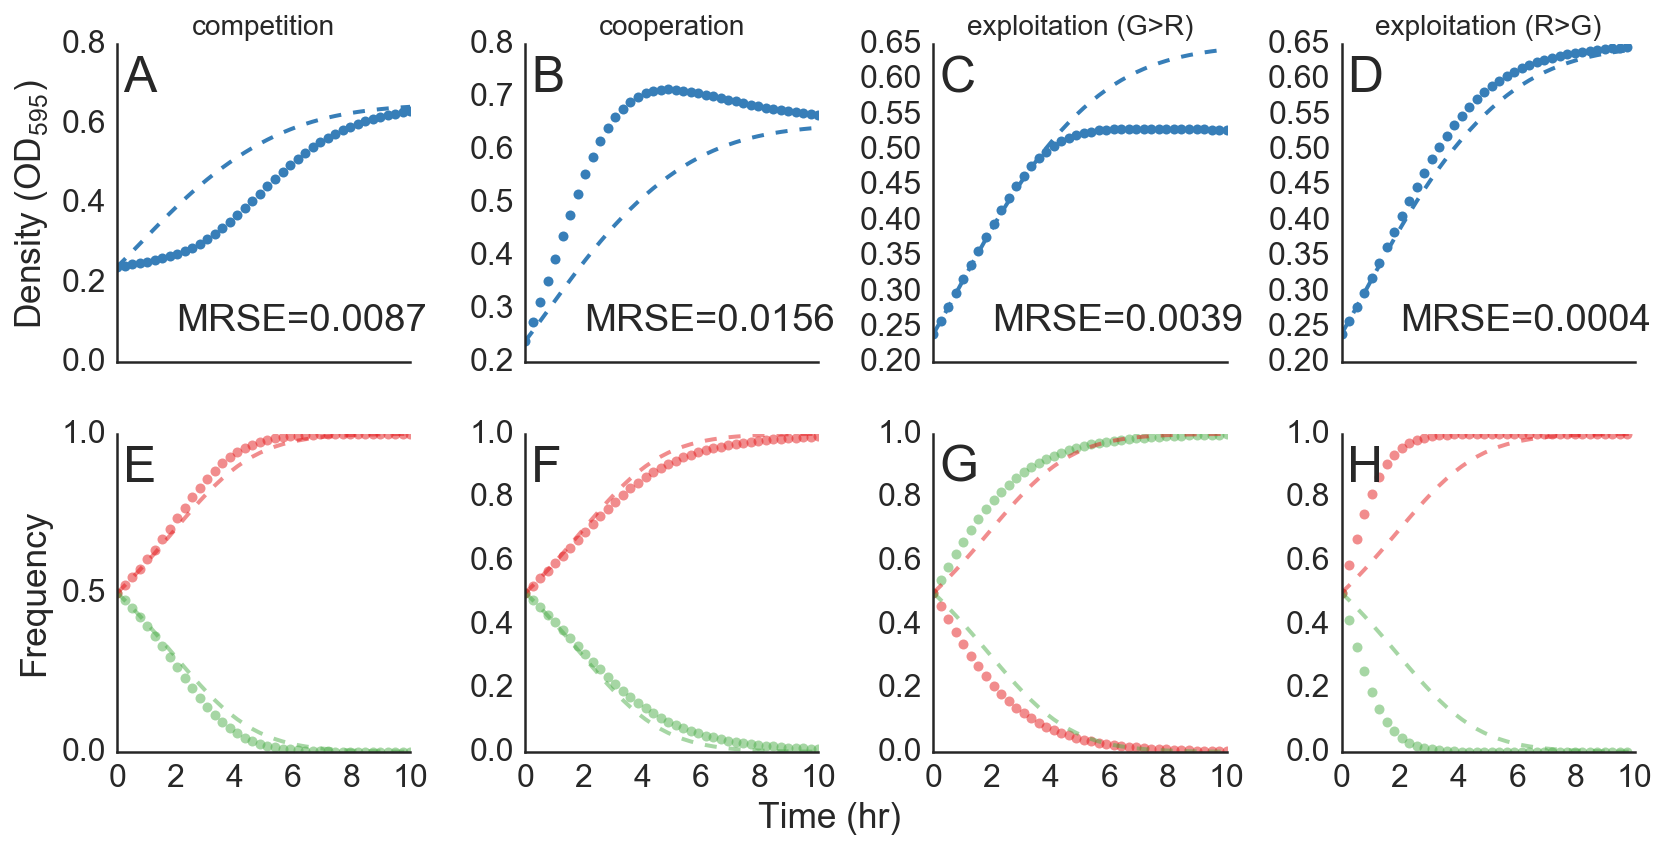

In [248]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=False)
kws = dict(marker='o', markersize=5, ls='')


for i, γ in enumerate((γ_a, γ_b, γ_c, γ_d)):
    y_mixed = cache[γ]['y_mixed']
    y_mixed_sum = y_mixed.sum(axis=1)
    axes[1,i].plot(t, y_mixed[:,0]/y_mixed_sum, color=green, alpha=0.5, **kws)
    axes[1,i].plot(t, y_mixed[:,1]/y_mixed_sum, color=red, alpha=0.5, **kws)
    axes[0,i].plot(t, y_mixed_sum, color=blue, **kws)
    
    y_pred = cache[γ]['y_pred']
    t_pred = cache[γ]['t_pred']
    y_pred_sum = y_pred.sum(axis=1)
    axes[1,i].plot(t_pred, y_pred[:,0]/y_pred_sum, color=green, ls='--', alpha=0.5, lw=2)
    axes[1,i].plot(t_pred, y_pred[:,1]/y_pred_sum, color=red, ls='--', alpha=0.5, lw=2)
    axes[0,i].plot(t_pred, y_pred_sum, color=blue, ls='--', lw=2)

    axes[0,i].annotate('MRSE={:.4f}'.format(cache[γ]['MRSE']), (0.2, 0.1), xycoords='axes fraction')
    axes[0,i].set(xlabel='', ylabel='')
#     axes[0,i].set_title('$\gamma_1={}, \gamma_2={}$'.format(*γ), fontsize=12)
    axes[0,i].set_title(titles[i], fontsize=14)

axes[0,0].set(yticks=[0, 0.2, 0.4, 0.6, 0.8], ylabel=r'Density ($OD_{595}$)')
axes[1,0].set(yticks=[0, 0.5, 1.0], ylabel='Frequency')
txt_x = fig_xlabel(fig, 'Time (hr)')
fig_panel_labels(axes, xcoord=0.02, ycoord=0.85, panel_label_size=panel_label_size)
fig.tight_layout()
sns.despine()

## Colophon

This notebook was written by [Yoav Ram](http://www.yoavram.com) ([yoav@yoavram.com](mailto:yoav@yoavram.com)) and is part of the supporting material for a manuscript.

The notebook was written using Python 3.5, IPython 4.2, Jupyter 4, NumPy 1.11, SciPy 0.17, Pandas 0.18, Matplotlib 1.5, lmfit 0.9.3, Seaborn 0.7, Scikit-learn 0.17, but should work with Python 3.4 and Python 2.7 and earlier versions of most of the packages (lmfit should be at least 0.9.3).

This work is licensed under a CC BY-SA 4.0 International License. Attribution should be given by citing the original manuscript.